In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import shap
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score

In [2]:
df = pd.read_csv("data/cleaned_data_eda.csv")

In [3]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,EducationField,Gender,HourlyRate,JobRole,...,OverTime,PercentSalaryHike,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,AgeBand,CompanyAgeBand
0,41,Yes,Travel_Rarely,1102,Sales,1,Life Sciences,Female,94,Sales Executive,...,Yes,11,8,0,6,4,0,5,41–50,0–10
1,49,No,Travel_Frequently,279,Research & Development,8,Life Sciences,Male,61,Research Scientist,...,No,23,10,3,10,7,1,7,41–50,0–10
2,37,Yes,Travel_Rarely,1373,Research & Development,2,Other,Male,92,Laboratory Technician,...,Yes,15,7,3,0,0,0,0,31–40,NaN
3,33,No,Travel_Frequently,1392,Research & Development,3,Life Sciences,Female,56,Research Scientist,...,Yes,11,8,3,8,7,3,0,31–40,0–10
4,27,No,Travel_Rarely,591,Research & Development,2,Medical,Male,40,Laboratory Technician,...,No,12,6,3,2,2,2,2,18–30,0–10


In [4]:
df.isnull().sum()

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
EducationField              0
Gender                      0
HourlyRate                  0
JobRole                     0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
OverTime                    0
PercentSalaryHike           0
TotalWorkingYears           0
TrainingTimesLastYear       0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
AgeBand                     8
CompanyAgeBand             44
dtype: int64

The null values are because 0 is not included in bands
- We will fill these values with 0

In [5]:
df['AgeBand'] = df['AgeBand'].fillna(0)

In [6]:
df['CompanyAgeBand']=df['CompanyAgeBand'].fillna(0)

In [7]:
df.to_csv("data/cleaned_data_eda.csv", index=False)

#### Age and YearsInCompany were used to create columns AgeBand and CompanyAgeBand
- Keeping both is not necessary
- We will keep bands for logistic regression as it works well with banded features (weighted columns)
- We will keep numerical columns for Decision trees as it can work better on raw numerical data  
We will create a different pipeline for each 

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Age                      1470 non-null   int64 
 1   Attrition                1470 non-null   object
 2   BusinessTravel           1470 non-null   object
 3   DailyRate                1470 non-null   int64 
 4   Department               1470 non-null   object
 5   DistanceFromHome         1470 non-null   int64 
 6   EducationField           1470 non-null   object
 7   Gender                   1470 non-null   object
 8   HourlyRate               1470 non-null   int64 
 9   JobRole                  1470 non-null   object
 10  MaritalStatus            1470 non-null   object
 11  MonthlyIncome            1470 non-null   int64 
 12  MonthlyRate              1470 non-null   int64 
 13  NumCompaniesWorked       1470 non-null   int64 
 14  OverTime                 1470 non-null  

In [9]:
# Replace en dash (–) with hyphen-minus (-) in all band columns
df['AgeBand'] = df['AgeBand'].astype(str).str.replace('–', '-', regex=False)
df['CompanyAgeBand'] = df['CompanyAgeBand'].astype(str).str.replace('–', '-', regex=False)

# Convert integer 0 to string '0' in both columns (so types match)
df['AgeBand'] = df['AgeBand'].astype(str)
df['CompanyAgeBand'] = df['CompanyAgeBand'].astype(str)

In [10]:
df['BusinessTravel'].unique()

array(['Travel_Rarely', 'Travel_Frequently', 'Non-Travel'], dtype=object)

#### Ordinal data
- Non-Travel: 0
- Travel_Rarely: 1
- Travel_Frequently: 2

In [11]:
df['AgeBand'].unique()

array(['41-50', '31-40', '18-30', '51-60', '0'], dtype=object)

#### Ordinal data
- 0: 0
- 18-30: 1
- 31-40: 2
- 41-50: 3
- 51-60: 4

In [12]:
df['CompanyAgeBand'].unique()

array(['0-10', '0', '21-30', '11-20', '31-40'], dtype=object)

#### Ordinal data
- 0: 0
- 0-10: 1
- 11-20: 2
- 21-30: 3
- 31-40: 4

In [13]:
df['Department'].unique()

array(['Sales', 'Research & Development', 'Human Resources'], dtype=object)

#### Nominal data

In [14]:
df['EducationField'].unique()

array(['Life Sciences', 'Other', 'Medical', 'Marketing',
       'Technical Degree', 'Human Resources'], dtype=object)

#### Nominal data

In [15]:
df['Gender'].unique()

array(['Female', 'Male'], dtype=object)

#### Nominal data

In [16]:
df['JobRole'].unique()

array(['Sales Executive', 'Research Scientist', 'Laboratory Technician',
       'Manufacturing Director', 'Healthcare Representative', 'Manager',
       'Sales Representative', 'Research Director', 'Human Resources'],
      dtype=object)

#### Nominal data

In [17]:
df['MaritalStatus'].unique()

array(['Single', 'Married', 'Divorced'], dtype=object)

#### Nominal data

In [18]:
df['OverTime'].unique()

array(['Yes', 'No'], dtype=object)

#### Nominal data

In [19]:
df['Attrition'].unique()

array(['Yes', 'No'], dtype=object)

#### Nominal data (Label Encoding)
We will apply label encoding for target variable

In [20]:
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})

# Train-Test Split

In [21]:
# Raw numeric version (for tree-based model)
X_tree = df.drop(['Attrition', 'AgeBand', 'CompanyAgeBand'], axis=1)
# Binned version (for logistic regression)
X_logit = df.drop(['Attrition', 'Age', 'YearsAtCompany'], axis=1)

y = df['Attrition']

In [22]:
# For Decision Tree
X_tree_train, X_tree_test, y_tree_train, y_tree_test = train_test_split(
    X_tree, y, test_size=0.2)

# For Logistic Regression
X_logit_train, X_logit_test, y_logit_train, y_logit_test = train_test_split(
    X_logit, y, test_size=0.2)

## Column Encoding types and Pipeline

In [23]:
def get_column_types(df):
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    cat_cols = df.select_dtypes(include='object').columns.tolist()
    return num_cols, cat_cols

In [24]:
# For Logistic Regression
num_cols_logit, cat_cols_logit = get_column_types(X_logit_train)
ordinal_cols_logit = ['BusinessTravel', 'AgeBand', 'CompanyAgeBand']
nominal_cols_logit = list(set(cat_cols_logit) - set(ordinal_cols_logit))

In [25]:
#For Decision Tree
num_cols_tree, cat_cols_tree = get_column_types(X_tree_train)
ordinal_cols_tree = ['BusinessTravel']
nominal_cols_tree = list(set(cat_cols_tree) - set(ordinal_cols_tree))

In [26]:
# Shared Pipeline
numerical_pipeline = SimpleImputer(strategy='mean')

In [27]:
ordinal_pipeline_logit = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(categories=[
        ['Non-Travel', 'Travel_Rarely', 'Travel_Frequently'],  # BusinessTravel
        ['0', '18-30', '31-40', '41-50', '51-60'],             # AgeBand
        ['0', '0-10', '11-20', '21-30', '31-40']               # CompanyAgeBand
    ]))
])

ordinal_pipeline_tree = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(categories=[
        ['Non-Travel', 'Travel_Rarely', 'Travel_Frequently']   # Only BusinessTravel
    ]))
])

In [28]:
nominal_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

## Preprocessors

In [29]:
# Logistic Regression Preprocessor
preprocessor_logit = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, num_cols_logit),
    ('ord', ordinal_pipeline_logit, ordinal_cols_logit),
    ('nom', nominal_pipeline, nominal_cols_logit)
])

# Decision Tree Preprocessor
preprocessor_tree = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, num_cols_tree),
    ('ord', ordinal_pipeline_tree, ordinal_cols_tree),
    ('nom', nominal_pipeline, nominal_cols_tree)
])

# 🌟 Model Fitting & Evaluation

## 🔶 Logistic Regression

In [30]:
logit_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_logit),
    ('classifier', LogisticRegression(max_iter=1000))
])

logit_pipeline.fit(X_logit_train, y_logit_train)
y_logit_pred = logit_pipeline.predict(X_logit_test)

print("🔶 Logistic Regression Accuracy:", accuracy_score(y_logit_test, y_logit_pred))
print("📊 Classification Report:\n", classification_report(y_logit_test, y_logit_pred))

🔶 Logistic Regression Accuracy: 0.8537414965986394
📊 Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.99      0.92       243
           1       0.83      0.20      0.32        51

    accuracy                           0.85       294
   macro avg       0.84      0.59      0.62       294
weighted avg       0.85      0.85      0.81       294



# 🔷 Decision Tree 

In [31]:
tree_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_tree),
    ('classifier', DecisionTreeClassifier(max_depth=5, random_state=42))
])

tree_pipeline.fit(X_tree_train, y_tree_train)
y_tree_pred = tree_pipeline.predict(X_tree_test)

print("🌳 Decision Tree Accuracy:", accuracy_score(y_tree_test, y_tree_pred))
print("📊 Classification Report:\n", classification_report(y_tree_test, y_tree_pred))

🌳 Decision Tree Accuracy: 0.8197278911564626
📊 Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.95      0.90       247
           1       0.35      0.15      0.21        47

    accuracy                           0.82       294
   macro avg       0.60      0.55      0.55       294
weighted avg       0.77      0.82      0.79       294



# Confusion Matrix

### Logistic Regression

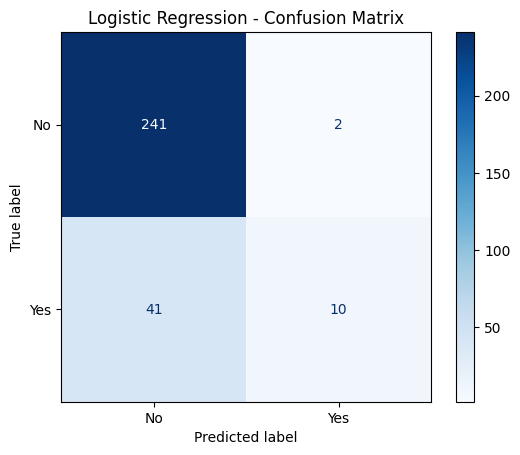

In [32]:
cm_logit = confusion_matrix(y_logit_test, y_logit_pred)
disp_logit = ConfusionMatrixDisplay(confusion_matrix=cm_logit, display_labels=['No', 'Yes'])
disp_logit.plot(cmap='Blues')
plt.title("Logistic Regression - Confusion Matrix")
plt.show()

#### Insights
- The model works well with prediction No attrition (good performance with True-Negative values)
- The model does not perform so well when predicting Attirion True values (higher number of False-Negative values)

### Decision Tree

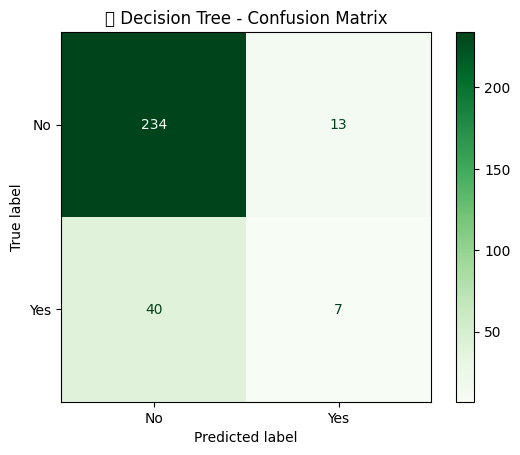

In [33]:
cm_tree = confusion_matrix(y_tree_test, y_tree_pred)
disp_tree = ConfusionMatrixDisplay(confusion_matrix=cm_tree, display_labels=['No', 'Yes'])
disp_tree.plot(cmap='Greens')
plt.title("🌳 Decision Tree - Confusion Matrix")
plt.show()

#### Insights
- We can see that Decision Tree works worse than Logistic Regression as it has higher number of FN and FP values

# Model Comparison

In [34]:
def print_metrics(name, y_test, y_pred):
    print(f"📊 {name} Performance")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("-" * 50)

print_metrics("Logistic Regression", y_logit_test, y_logit_pred)
print_metrics("Decision Tree", y_tree_test, y_tree_pred)

📊 Logistic Regression Performance
Accuracy: 0.8537414965986394
Precision: 0.8333333333333334
Recall: 0.19607843137254902
F1 Score: 0.31746031746031744
--------------------------------------------------
📊 Decision Tree Performance
Accuracy: 0.8197278911564626
Precision: 0.35
Recall: 0.14893617021276595
F1 Score: 0.208955223880597
--------------------------------------------------


### Insights
#### Logistic Regression:
- More precise: When it predicts someone will leave, it’s usually correct.
- But misses many actual leavers (low recall = only 24% captured).
- This model is cautious — it avoids false alarms but fails to catch many true cases.
- Suggested for Minimizing false alarms
#### Decision Tree
- More balanced: Slightly better recall, slightly higher F1 score.
- But lower precision: It makes more false attrition predictions than Logistic Regression.
- This model is more aggressive in flagging attrition but takes more risk.
- Suggested for Catching more attrition cases

# SHAP Values

## Logistic Regression

In [35]:
X_logit_processed = preprocessor_logit.fit_transform(X_logit_train)

In [36]:
#Get feature names after one-hot + ordinal encoding
feature_names = (
    preprocessor_logit.transformers_[0][2] +                     # numeric columns
    ordinal_cols_logit +                                        # ordinal
    list(preprocessor_logit.transformers_[2][1].named_steps['encoder'].get_feature_names_out(nominal_cols_logit))  # nominal one-hot
)

In [37]:
#Explainer + SHAP values
explainer = shap.Explainer(logit_pipeline.named_steps['classifier'], X_logit_processed, feature_names=feature_names)
shap_values_logit = explainer(X_logit_processed)

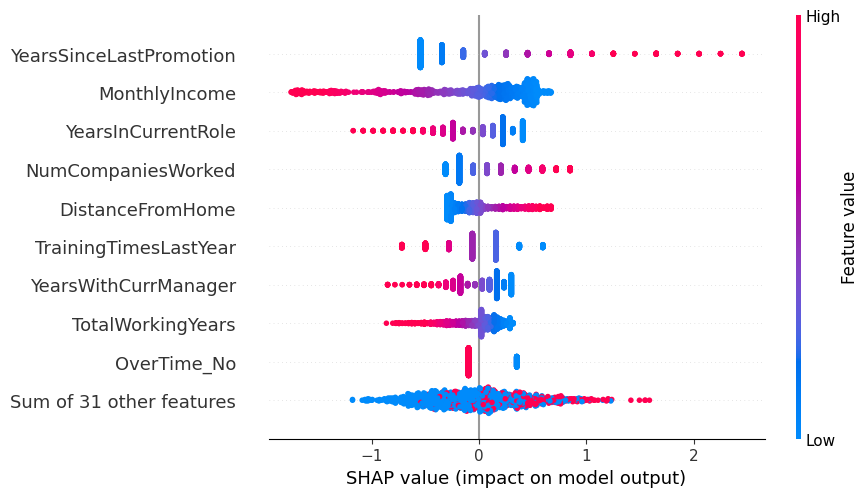

In [38]:
#Summary plot
shap.plots.beeswarm(shap_values_logit)

#### Insights
- Lack of promotions, low role tenure, and low manager stability are strong predictors of attrition.
- Overtime and low pay are clear stressors.
- Employees early in their careers (younger age bands) are more likely to leave — common across industries.
- Training may correlate with ambition — but too much without reward could backfire.

## Decision Tree

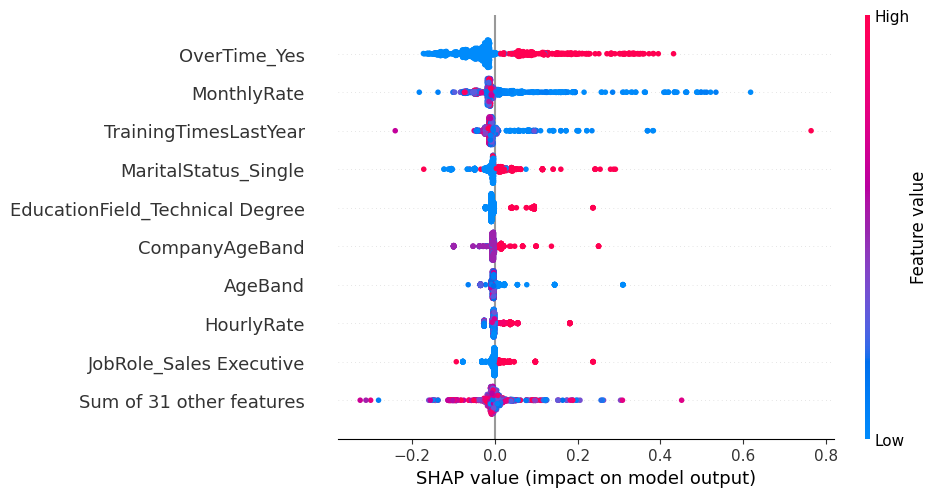

In [39]:
model_tree = tree_pipeline.named_steps['classifier']
X_tree_raw = preprocessor_tree.transform(X_tree_train)
X_tree_df = pd.DataFrame(X_tree_raw, columns=feature_names)
explainer = shap.Explainer(model_tree, X_tree_df)
shap_values_tree = explainer(X_tree_df)

shap.plots.beeswarm(shap_values_tree[..., 1]) 

#### Insights
- Factors like Higher Monthly Income, More experience (TotalWorkingYears), Being older, staying longer reduce chances of attrition significantly.
- Employees who have been with the organization longer and are older are less likely to resign. This aligns with the idea that longer tenure reflects stronger bonds with teams, culture, stability and company mission.
- Younger employees, new joiners with short tenure, and those with a history of frequent job changes are more likely to leave. These individuals may be in exploratory phases of their careers, seeking faster growth or more aligned roles.
- Employees working overtime and those in high-stress roles like Sales Executive face higher attrition risk. Long hours and demanding performance expectations can lead to burnout or dissatisfaction.
- Single employees and those earning lower salaries are more likely to resign. These factors may reflect greater personal flexibility, mobility, or financial dissatisfaction. Ensuring equitable compensation, offering financial growth pathways, and building inclusive engagement strategies for diverse life situations can help improve retention in this group.

## Conclusion
- Both models agree on major drivers like overtime, income, tenure, and age.
- The Decision Tree captures nonlinear interactions, picking up job history and role-specific nuances.

In [40]:
#Saving Confusion Matrix
# Logistic
ConfusionMatrixDisplay.from_estimator(logit_pipeline, X_logit_test, y_logit_test,
                                      display_labels=["No", "Yes"],
                                      cmap='Blues')
plt.title("Logistic Regression - Confusion Matrix")
plt.savefig("logistic_confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.close()

# Decision Tree
ConfusionMatrixDisplay.from_estimator(tree_pipeline, X_tree_test, y_tree_test,
                                      display_labels=["No", "Yes"],
                                      cmap='Greens')
plt.title("Decision Tree - Confusion Matrix")
plt.savefig("tree_confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.close()

In [41]:
# Saving Classification Report
logit_report = classification_report(y_logit_test, y_logit_pred, target_names=['No', 'Yes'])
tree_report = classification_report(y_tree_test, y_tree_pred, target_names=['No', 'Yes'])

# Save to text file
with open("model_accuracy_report.txt", "w", encoding="utf-8") as f:
    f.write("📊 Logistic Regression Performance:\n")
    f.write(logit_report)
    f.write("\n" + "-"*60 + "\n")
    f.write("🌳 Decision Tree Performance:\n")
    f.write(tree_report)

In [42]:
# Saving SHAP Summary
# Logistic
shap.plots.beeswarm(shap_values_logit, show=False)
plt.title("Logistic Regression - SHAP Summary")
plt.savefig("logistic_shap_summary.png", dpi=300, bbox_inches='tight')
plt.close()

# Decision Tree
shap.plots.beeswarm(shap_values_tree[..., 1], show=False)
plt.title("Decision Tree - SHAP Summary")
plt.savefig("tree_shap_summary.png", dpi=300, bbox_inches='tight')
plt.close()

In [ ]:
df.to_csv("data/cleaned_data_eda.csv", index=False)